In [ ]:
%reset #clear the ipython workspace variables

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #clear, please run `%reset?` for details
Don't know how to reset  the, please run `%reset?` for details
Don't know how to reset  ipython, please run `%reset?` for details
Don't know how to reset  workspace, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details


In [ ]:
#select that same tensorflow version as Training Script
%tensorflow_version 2.x

In [ ]:
#Import Statements
import os
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate
from scipy.optimize import curve_fit

from numpy import array
import joblib
import sys

import math
from math import sqrt

import tensorflow as tf
from tensorflow.python.client import device_lib



In [ ]:
#let ping the GPU and see what colab gave us...
print(tf.test.gpu_device_name())
print(device_lib.list_local_devices())

#let's also check version of tf and if eager is on.
print(tf.executing_eagerly())
print(tf.__version__)
print(keras.__version__)


/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9319915459707457931
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4579309639067314918
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]
True
2.7.0
2.7.0


In [ ]:
#Change plot settings
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

In [ ]:
#data is on google drive so need to load
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#this line needs to be changed depending on file structure of google drive
#os.chdir('/content/drive/MyDrive/WVU_GradStudents_ShareFolder/Jacob_Research/New LSTM Crack')
os.chdir('/content/drive/MyDrive/New LSTM Crack/')

# Functions

In [ ]:
def read_file(file_name):
  file = file_name
  return pd.read_csv(file)

In [ ]:
def create_prediction_data(prediction_data):
  data_array = np.asarray(prediction_data)
  
  temp_data = data_array[:, 0]
  temp_series = (temp_data / np.amax(temp_data)).reshape(len(data_array), 1)

  stress_intensity = Scaler.transform(data_array[:, 1].reshape(len(data_array), 1))

  return np.hstack((temp_series, stress_intensity))

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern. copy in groups?
		seq_x, seq_y = sequences[i:end_ix, 1:], sequences[end_ix, 0]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
def create_actual_data(file_name):
  file = pd.read_csv(file_name)
  data_array = np.asarray(file)
  crack_length = data_array[:, 1]
  return crack_length

# Loading Data

In [ ]:
#Load previously trained model
model = keras.models.load_model("./Weights/Model_HT_5_21_21_TM")
print("Model Loaded")

Model Loaded


In [ ]:
#Load in the experimental data
#['./Training/HeatTreated/t150_4-12-21_R05_1800N_training.csv', './Training/HeatTreated/t150_4-13-21_R05_1700N_training.csv', 
#'./Training/HeatTreated/t150_4-15-21_R05_1600N_training.csv', './Training/HeatTreated/t250_4-21-21_R05_1800N_training.csv', 
#'./Training/HeatTreated/t250_4-7-21_R05_1700N_training.csv', './Training/HeatTreated/t250_4-8-21_R05_1600N_training.csv', 
#'./Training/HeatTreated/t35_4-19-21_R05_1800N_training.csv', './Training/HeatTreated/t35_4-2-21_R05_1700N_training.csv']

data_1600_35 = np.asarray(pd.read_csv('./Training/HeatTreated/hold/t35_4-3-21_R05_1600N_training.bak'))
data_1700_35 = np.asarray(pd.read_csv('./Training/HeatTreated/t35_4-2-21_R05_1700N_training.csv'))
data_1800_35 = np.asarray(pd.read_csv('./Training/HeatTreated/t35_4-19-21_R05_1800N_training.csv'))

data_1600_150 = np.asarray(pd.read_csv('./Training/HeatTreated/t150_4-15-21_R05_1600N_training.csv'))
data_1700_150 = np.asarray(pd.read_csv('./Training/HeatTreated/t150_4-13-21_R05_1700N_training.csv'))
data_1800_150 = np.asarray(pd.read_csv('./Training/HeatTreated/t150_4-12-21_R05_1800N_training.csv'))

data_1600_250 = np.asarray(pd.read_csv('./Training/HeatTreated/t250_4-8-21_R05_1600N_training.csv'))
data_1700_250 = np.asarray(pd.read_csv('./Training/HeatTreated/t250_4-7-21_R05_1700N_training.csv'))
data_1800_250 = np.asarray(pd.read_csv('./Training/HeatTreated/t250_4-21-21_R05_1800N_training.csv'))

#Load in the extrapolated data
w_noise = 2 # load data with guassian noise 0=no 1=yes
if w_noise > 1:
  #75C
  data_1600_75 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_348K_noise.csv'))
  data_1700_75 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_348K_noise.csv'))
  data_1800_75 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_348K_noise.csv'))
  #200C
  data_1600_200 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_473K_noise.csv'))
  data_1700_200 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_473K_noise.csv'))
  data_1800_200 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_473K_noise.csv'))
  #300C
  data_1600_300 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_573K_noise.csv'))
  data_1700_300 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_573K_noise.csv'))
  data_1800_300 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_573K_noise.csv'))
  #400C
  data_1600_400 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_673K_noise.csv'))
  data_1700_400 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_673K_noise.csv'))
  data_1800_400 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_673K_noise.csv'))
  #500C
  data_1600_500 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_773K_noise.csv'))
  data_1700_500 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_773K_noise.csv'))
  data_1800_500 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_773K_noise.csv'))
  print('Data Loaded')
else:
  #75C
  data_1600_75 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_348K.csv'))
  data_1700_75 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_348K.csv'))
  data_1800_75 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_348K.csv'))
  #200C
  data_1600_200 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_473K.csv'))
  data_1700_200 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_473K.csv'))
  data_1800_200 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_473K.csv'))
  #300C
  data_1600_300 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_573K.csv'))
  data_1700_300 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_573K.csv'))
  data_1800_300 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_573K.csv'))
  #400C
  data_1600_400 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_673K.csv'))
  data_1700_400 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_673K.csv'))
  data_1800_400 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_673K.csv'))
  #500C
  data_1600_500 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_773K.csv'))
  data_1700_500 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_773K.csv'))
  data_1800_500 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_773K.csv'))

Data Loaded


In [ ]:
#this function computes how to offset the initial crackheight. should be set to zero.
def auto_crackoffset(crack_series):
  crack_avg = 0
  crack_offset = 0
  num_avg = 100
  #for i in range(0,num_avg):
  #  crack_avg += crack_series[i]
  crack_offset = np.max(crack_series[0:100]) #ended up offsetting my maximum value in the first 100 entries.
  return -crack_offset

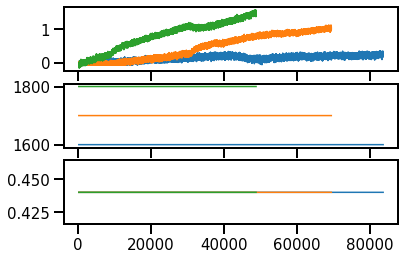

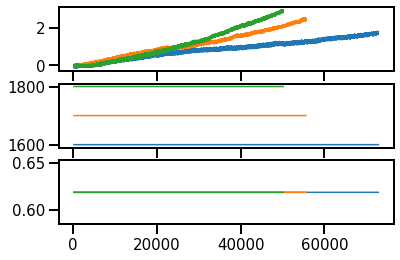

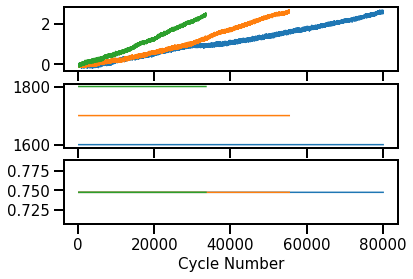

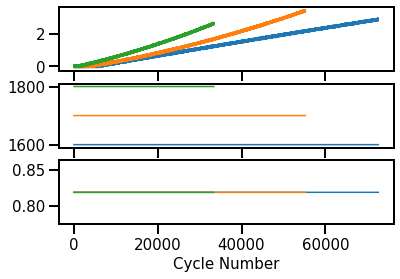

In [ ]:
#Read in the DATA - !!WARNING NEEDS TO BE CONSISTENT WITH TRAINING DATA!!

#Offset Crack to Zero by reading first 100 crack entries and offsetting to zero
offset_crack = 1 # 0=no 1=yes

# time
time_1600_35 = data_1600_35[:,0];time_1700_35 = data_1700_35[:,0];time_1800_35 = data_1800_35[:,0]
time_1600_150 = data_1600_150[:,0];time_1700_150 = data_1700_150[:,0];time_1800_150 = data_1800_150[:,0]
time_1600_250 = data_1600_250[:,0];time_1700_250 = data_1700_250[:,0];time_1800_250 = data_1800_250[:,0]
#extrapolated data
time_1600_75 = data_1600_75[:,0];time_1700_75 = data_1700_75[:,0];time_1800_75 = data_1800_75[:,0]
time_1600_200 = data_1600_200[:,0];time_1700_200 = data_1700_200[:,0];time_1800_200 = data_1800_200[:,0]
time_1600_300 = data_1600_300[:,0];time_1700_300 = data_1700_300[:,0];time_1800_300 = data_1800_300[:,0]
time_1600_400 = data_1600_400[:,0];time_1700_400 = data_1700_400[:,0];time_1800_400 = data_1800_400[:,0]
time_1600_500 = data_1600_500[:,0];time_1700_500 = data_1700_500[:,0];time_1800_500 = data_1800_500[:,0]

# crack length
if offset_crack > 0:
  crack_1600_35  = data_1600_35[:,1] +auto_crackoffset(data_1600_35[:,1]);crack_1700_35 = data_1700_35[:,1]+auto_crackoffset(data_1700_35[:,1]);crack_1800_35 = data_1800_35[:,1]+auto_crackoffset(data_1800_35[:,1])
  crack_1600_150 = data_1600_150[:,1]+auto_crackoffset(data_1600_150[:,1]);crack_1700_150 = data_1700_150[:,1]+auto_crackoffset(data_1700_150[:,1]);crack_1800_150 = data_1800_150[:,1]+auto_crackoffset(data_1800_150[:,1])
  crack_1600_250 = data_1600_250[:,1]+auto_crackoffset(data_1600_250[:,1]);crack_1700_250 = data_1700_250[:,1]+auto_crackoffset(data_1700_250[:,1]);crack_1800_250 = data_1800_250[:,1]+auto_crackoffset(data_1800_250[:,1])
else:
  crack_1600_35  = data_1600_35[:,1];crack_1700_35 = data_1700_35[:,1];crack_1800_35 = data_1800_35[:,1]
  crack_1600_150 = data_1600_150[:,1];crack_1700_150 = data_1700_150[:,1];crack_1800_150 = data_1800_150[:,1]
  crack_1600_250 = data_1600_250[:,1];crack_1700_250 = data_1700_250[:,1];crack_1800_250 = data_1800_250[:,1]
#extrapolated data
crack_1600_75 = data_1600_75[:,1];crack_1700_75 = data_1700_75[:,1];crack_1800_75 = data_1800_75[:,1]
crack_1600_200 = data_1600_200[:,1];crack_1700_200 = data_1700_200[:,1];crack_1800_200 = data_1800_200[:,1]
crack_1600_300 = data_1600_300[:,1];crack_1700_300 = data_1700_300[:,1];crack_1800_300 = data_1800_300[:,1]
crack_1600_400 = data_1600_400[:,1];crack_1700_400 = data_1700_400[:,1];crack_1800_400 = data_1800_400[:,1]
crack_1600_500 = data_1600_500[:,1];crack_1700_500 = data_1700_500[:,1];crack_1800_500 = data_1800_500[:,1]

# force
force_1600_35 = data_1600_35[:,2];force_1700_35 = data_1700_35[:,2];force_1800_35 = data_1800_35[:,2]
force_1600_150 = data_1600_150[:,2];force_1700_150 = data_1700_150[:,2];force_1800_150 = data_1800_150[:,2]
force_1600_250 = data_1600_250[:,2];force_1700_250 = data_1700_250[:,2];force_1800_250 = data_1800_250[:,2]
#extrapolated data
force_1600_75 = data_1600_75[:,2];force_1700_75 = data_1700_75[:,2];force_1800_75 = data_1800_75[:,2]
force_1600_200 = data_1600_200[:,2];force_1700_200 = data_1700_200[:,2];force_1800_200 = data_1800_200[:,2]
force_1600_300 = data_1600_300[:,2];force_1700_300 = data_1700_300[:,2];force_1800_300 = data_1800_300[:,2]
force_1600_400 = data_1600_400[:,2];force_1700_400 = data_1700_400[:,2];force_1800_400 = data_1800_400[:,2]
force_1600_500 = data_1600_500[:,2];force_1700_500 = data_1700_500[:,2];force_1800_500 = data_1800_500[:,2]

# normalize the temperature series data by 700K
temp_1600_35 = data_1600_35[:,3]/700;temp_1700_35 = data_1700_35[:,3]/700;temp_1800_35 = data_1800_35[:,3]/700
temp_1600_150 = data_1600_150[:,3]/700;temp_1700_150 = data_1700_150[:,3]/700;temp_1800_150 = data_1800_150[:,3]/700
temp_1600_250 = data_1600_250[:,3]/700;temp_1700_250 = data_1700_250[:,3]/700;temp_1800_250 = data_1800_250[:,3]/700
#extrapolated data
temp_1600_75 = data_1600_300[:,3]/700;temp_1700_75 = data_1700_75[:,3]/700;temp_1800_75 = data_1800_75[:,3]/700
temp_1600_200 = data_1600_200[:,3]/700;temp_1700_200 = data_1700_200[:,3]/700;temp_1800_200 = data_1800_200[:,3]/700
temp_1600_300 = data_1600_300[:,3]/700;temp_1700_300 = data_1700_300[:,3]/700;temp_1800_300 = data_1800_300[:,3]/700
temp_1600_400 = data_1600_400[:,3]/700;temp_1700_400 = data_1700_400[:,3]/700;temp_1800_400 = data_1800_400[:,3]/700
temp_1600_500 = data_1600_500[:,3]/700;temp_1700_500 = data_1700_500[:,3]/700;temp_1800_500 = data_1800_500[:,3]/700

#let's plot the data to see what is going on
fig, (ax1c1,ax2c1,ax3c1) = plt.subplots(3,1, sharex=True)
#Column 1
ax1c1.plot(time_1600_35[:,],crack_1600_35[:,], '-', label='35C 1600N') # 
ax1c1.plot(time_1700_35[:,],crack_1700_35[:,], '-', label='35C 1700N') # 
ax1c1.plot(time_1800_35[:,],crack_1800_35[:,], '-', label='35C 1800N') # 
ax2c1.plot(time_1600_35[:,],force_1600_35[:,], '-', label='35C 1600N')
ax2c1.plot(time_1700_35[:,],force_1700_35[:,], '-', label='35C 1700N')
ax2c1.plot(time_1800_35[:,],force_1800_35[:,], '-', label='35C 1800N')
ax3c1.plot(time_1600_35[:,],temp_1600_35[:,], '-', label='35C 1600N')
ax3c1.plot(time_1700_35[:,],temp_1700_35[:,], '-', label='35C 1700N')
ax3c1.plot(time_1800_35[:,],temp_1800_35[:,], '-', label='35C 1800N')

fig2, (ax1c2,ax2c2,ax3c2) = plt.subplots(3,1, sharex=True)
#Column 2
ax1c2.plot(time_1600_150[:,],crack_1600_150[:,], '-', label='150C 1600N') # 
ax1c2.plot(time_1700_150[:,],crack_1700_150[:,], '-', label='150C 1700N') # 
ax1c2.plot(time_1800_150[:,],crack_1800_150[:,], '-', label='150C 1800N') # 
ax2c2.plot(time_1600_150[:,],force_1600_150[:,], '-', label='150C 1600N')
ax2c2.plot(time_1700_150[:,],force_1700_150[:,], '-', label='150C 1700N')
ax2c2.plot(time_1800_150[:,],force_1800_150[:,], '-', label='150C 1800N')
ax3c2.plot(time_1600_150[:,],temp_1600_150[:,], '-', label='150C 1600N')
ax3c2.plot(time_1700_150[:,],temp_1700_150[:,], '-', label='150C 1700N')
ax3c2.plot(time_1800_150[:,],temp_1800_150[:,], '-', label='150C 1800N')

fig3, (ax1c3,ax2c3,ax3c3) = plt.subplots(3,1, sharex=True)
#Column 3
ax1c3.plot(time_1600_250[:,],crack_1600_250[:,], '-', label='250C 1600N') # 
ax1c3.plot(time_1700_250[:,],crack_1700_250[:,], '-', label='250C 1700N') # 
ax1c3.plot(time_1800_250[:,],crack_1800_250[:,], '-', label='250C 1800N') # 
ax2c3.plot(time_1600_250[:,],force_1600_250[:,], '-', label='250C 1600N')
ax2c3.plot(time_1700_250[:,],force_1700_250[:,], '-', label='250C 1700N')
ax2c3.plot(time_1800_250[:,],force_1800_250[:,], '-', label='250C 1800N')
ax3c3.plot(time_1600_250[:,],temp_1600_250[:,], '-', label='250C 1600N')
ax3c3.plot(time_1700_250[:,],temp_1700_250[:,], '-', label='250C 1700N')
ax3c3.plot(time_1800_250[:,],temp_1800_250[:,], '-', label='250C 1800N')
plt.xlabel('Cycle Number')
plt.show()

fig4, (ax1c4,ax2c4,ax3c4) = plt.subplots(3,1, sharex=True)
#Column 3
ax1c4.plot(time_1600_300[:,],crack_1600_300[:,], '-', label='300C 1600N') # 
ax1c4.plot(time_1700_300[:,],crack_1700_300[:,], '-', label='300C 1700N') # 
ax1c4.plot(time_1800_300[:,],crack_1800_300[:,], '-', label='300C 1800N') # 
ax2c4.plot(time_1600_300[:,],force_1600_300[:,], '-', label='300C 1600N')
ax2c4.plot(time_1700_300[:,],force_1700_300[:,], '-', label='300C 1700N')
ax2c4.plot(time_1800_300[:,],force_1800_300[:,], '-', label='300C 1800N')
ax3c4.plot(time_1600_300[:,],temp_1600_300[:,], '-', label='300C 1600N')
ax3c4.plot(time_1700_300[:,],temp_1700_300[:,], '-', label='300C 1700N')
ax3c4.plot(time_1800_300[:,],temp_1800_300[:,], '-', label='300C 1800N')
plt.xlabel('Cycle Number')
plt.show()

#so it looks like it is concatenated 1800,1700,1600(med temperature) then 1800,1700,1600(high temperature) then 1800,1700,1600 (room temperature)
#don't quite understand the order or reasoning. but let's see if it works.

In [ ]:
#funtion to compute time step. we must maintain time step as we used when we trained the data
def avg_timestep(time_series):
  diff = 0
  w=0
  for i in range(0,len(time_series)-1):
    diff += time_series[i+1,]-time_series[i,]
    if time_series[i+1,]-time_series[i,]>0.196 and w<3:
      print('Warning!! Timestep Change > 0.196',i,time_series[i+1,]-time_series[i,])
      w+=1

  return diff/len(time_series)

In [ ]:
#funtion creates a timestep array
def timestep_arr(time_series):
  diff = 0
  ts = []
  for i in range(0,len(time_series)-1):
    diff = time_series[i+1,]-time_series[i,]
    ts.append(diff)
  return np.array(ts)

Warning!! Timestep Change > 0.196 511 39.45312999999999
Warning!! Timestep Change > 0.196 1023 39.64843999999994
Warning!! Timestep Change > 0.196 1535 39.45312000000001
Average Time Sampling - 35C 0.2721710833708496
Warning!! Timestep Change > 0.196 511 39.648439999999994
Warning!! Timestep Change > 0.196 1022 39.64844000000005
Warning!! Timestep Change > 0.196 1534 39.64844000000039
Average Time Sampling - 150C 0.27215111960049565
Warning!! Timestep Change > 0.196 511 39.45312000000001
Warning!! Timestep Change > 0.196 1023 39.648439999999994
Warning!! Timestep Change > 0.196 1535 39.45312999999999
Average Time Sampling - 250C 0.26750528976972354
Warning!! Timestep Change > 0.196 511 39.45313
Warning!! Timestep Change > 0.196 1023 39.45312999999993
Warning!! Timestep Change > 0.196 1535 39.453130000000044
Average Time Sampling - 300C 0.2718759130170022


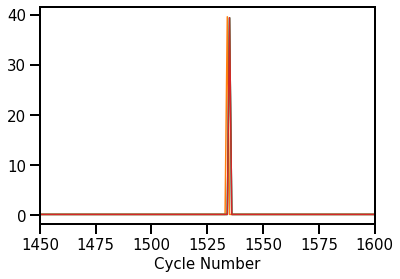

In [ ]:
#let's check the time
#check time step
tstep_1600_35 = timestep_arr(time_1600_35)
tstep_1600_150 = timestep_arr(time_1600_150)
tstep_1600_200 = timestep_arr(time_1600_250)
#extrapolated
tstep_1600_75 = timestep_arr(time_1600_75)
tstep_1600_200 = timestep_arr(time_1600_200)
tstep_1600_300 = timestep_arr(time_1600_300)
tstep_1600_200 = timestep_arr(time_1600_400)
tstep_1600_300 = timestep_arr(time_1600_500)

print('Average Time Sampling - 35C',avg_timestep(time_1600_35))
print('Average Time Sampling - 150C',avg_timestep(time_1600_150))
print('Average Time Sampling - 250C',avg_timestep(time_1600_250))
print('Average Time Sampling - 300C',avg_timestep(time_1600_300))

#
fig5, (ax1c4) = plt.subplots(1,1, sharex=True)
#Column 3
ax1c4.plot(tstep_1600_35[:,], '-', label='35C 1600N') # 
ax1c4.plot(tstep_1600_150[:,], '-', label='150C 1600N') # 
ax1c4.plot(tstep_1600_200[:,], '-', label='200C 1600N') # 
ax1c4.plot(tstep_1600_300[:,], '-', label='300C 1600N') # 
ax1c4.set_xlim([1450, 1600])
plt.xlabel('Cycle Number')
plt.show()

In [ ]:
#Function to calculate the stress intensity.
# we are being a little lazy here. Should create header file with these common functions.
#
#  !!!!!!! WARNING CHECK TO MAKE SURE SAME AS TRAINING FUNCTION  !!!!!!!!!!!
#
# Note: we offset by the initial crack stress intensity!!!!
#
def calc_stress_intensity(force_series,crack_series,a0_off):
  #Calculate the stress intensity
  #the geometry of the specimen had to be updated on 5/19/21
  stress_intensity = []
  intensity0 = 0
  #
  # Sample Parameters
  specimen_width = 34.63 #meters #40.8 mm new width 34.63mm
  thickness = 0.4572 #meters thickness of sample 0.4572mm
  a0 = 10 #initial crack length is 10mm
  crossSectArea = specimen_width*thickness #mm^2 to get MPa

  #looks like you are using the polynomial method derived from FEA to determine stress intensity
  for i in range(len(crack_series)):
    if crack_series[i]>0:
      if a0_off>0:
        #this first stress intensity is for the initial crack only
        term1 = (force_series[i] / crossSectArea) * sqrt(3.14159 * (a0)) #N/mm^2*sqrt(mm) = MPa*sqrt(mm)
        term2 = 1.122
        term3 = -0.231 * ((a0)  / specimen_width)
        term4 = 10.55 * (((a0) / specimen_width)**2)
        term5 = -21.71 * (((a0) / specimen_width)**3)
        term6 = 30.382 * (((a0) / specimen_width)**4)
        intensity0 = term1*(term2 + term3 + term4 + term5 + term6) #initial crack really only need to calculate for each load but wtf
      else:
        intensity0 = 0

      term1 = (force_series[i] / crossSectArea) * sqrt(3.14159 * (crack_series[i]+a0)) #N/mm^2*sqrt(mm) = MPa*sqrt(mm)
      term2 = 1.122
      term3 = -0.231 * ((crack_series[i]+a0)  / specimen_width)
      term4 = 10.55 * (((crack_series[i]+a0) / specimen_width)**2)
      term5 = -21.71 * (((crack_series[i]+a0) / specimen_width)**3)
      term6 = 30.382 * (((crack_series[i]+a0) / specimen_width)**4)
      intensity = term1*(term2 + term3 + term4 + term5 + term6)-intensity0 # basically shift SI down by initial crack value

    else:
      intensity = 0
    stress_intensity.append(intensity)
    if i % 100000 == 0:
      print(i)
  return np.array(stress_intensity)

In [ ]:
#Read Stress Intesnity Scaler from Training
Scaler = MinMaxScaler()
Scaler = joblib.load('./Weights/Scaler_HT_TM.save')
print(Scaler.get_params)

<bound method BaseEstimator.get_params of MinMaxScaler(copy=True, feature_range=(0, 1))>


0
100000
200000
300000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000


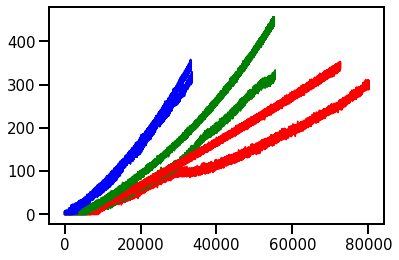

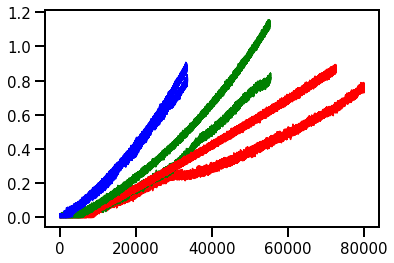

In [ ]:
#Calculate the stress intensity - 35C
si_1600_35_bt = calc_stress_intensity(force_1600_35,crack_1600_35,1)
si_1700_35_bt = calc_stress_intensity(force_1700_35,crack_1700_35,1)
si_1800_35_bt = calc_stress_intensity(force_1800_35,crack_1800_35,1)

#Calculate the stress intensity - 150C
si_1600_150_bt = calc_stress_intensity(force_1600_150,crack_1600_150,1)
si_1700_150_bt = calc_stress_intensity(force_1700_150,crack_1700_150,1)
si_1800_150_bt = calc_stress_intensity(force_1800_150,crack_1800_150,1)

#Calculate the stress intensity - 150C
si_1600_250_bt = calc_stress_intensity(force_1600_250,crack_1600_250,1)
si_1700_250_bt = calc_stress_intensity(force_1700_250,crack_1700_250,1)
si_1800_250_bt = calc_stress_intensity(force_1800_250,crack_1800_250,1)
#Extrapolated Data
#Calculate the stress intensity - 75C
si_1600_75_bt = calc_stress_intensity(force_1600_75,crack_1600_75,1)
si_1700_75_bt = calc_stress_intensity(force_1700_75,crack_1700_75,1)
si_1800_75_bt = calc_stress_intensity(force_1800_75,crack_1800_75,1)

#Calculate the stress intensity - 200C
si_1600_200_bt = calc_stress_intensity(force_1600_200,crack_1600_200,1)
si_1700_200_bt = calc_stress_intensity(force_1700_200,crack_1700_200,1)
si_1800_200_bt = calc_stress_intensity(force_1800_200,crack_1800_200,1)

#Calculate the stress intensity - 300C
si_1600_300_bt = calc_stress_intensity(force_1600_300,crack_1600_300,1)
si_1700_300_bt = calc_stress_intensity(force_1700_300,crack_1700_300,1)
si_1800_300_bt = calc_stress_intensity(force_1800_300,crack_1800_300,1)

#Calculate the stress intensity - 400C
si_1600_400_bt = calc_stress_intensity(force_1600_400,crack_1600_400,1)
si_1700_400_bt = calc_stress_intensity(force_1700_400,crack_1700_400,1)
si_1800_400_bt = calc_stress_intensity(force_1800_400,crack_1800_400,1)

#Calculate the stress intensity - 500C
si_1600_500_bt = calc_stress_intensity(force_1600_500,crack_1600_500,1)
si_1700_500_bt = calc_stress_intensity(force_1700_500,crack_1700_500,1)
si_1800_500_bt = calc_stress_intensity(force_1800_500,crack_1800_500,1)


#plot before scaling
fig2, (ax1c1) = plt.subplots(1,1, sharex=True)
#Column 1
#ax1c1.plot(time_1600_35[:,],si_1600_35[:,], 'r-', label='35C 1600N') # 
#ax1c1.plot(time_1700_35[:,],si_1700_35[:,], 'g-', label='35C 1700N') # 
#ax1c1.plot(time_1800_35[:,],si_1800_35[:,], 'b-', label='35C 1800N') #

#ax1c1.plot(time_1600_150[:,],si_1600_150[:,], 'r-', label='150C 1600N') # 
#ax1c1.plot(time_1700_150[:,],si_1700_150[:,], 'g-', label='150C 1700N') # 
#ax1c1.plot(time_1800_150[:,],si_1800_150[:,], 'b-', label='150C 1800N') # 

ax1c1.plot(time_1600_250[:,],si_1600_250_bt[:,], 'r-', label='250C 1600N') # 
ax1c1.plot(time_1700_250[:,],si_1700_250_bt[:,], 'g-', label='250C 1700N') # 
ax1c1.plot(time_1800_250[:,],si_1800_250_bt[:,], 'b-', label='250C 1800N') # 

ax1c1.plot(time_1600_300[:,],si_1600_300_bt[:,], 'r-', label='300C 1600N Expl') # 
ax1c1.plot(time_1700_300[:,],si_1700_300_bt[:,], 'g-', label='300C 1700N Expl') # 
ax1c1.plot(time_1800_300[:,],si_1800_300_bt[:,], 'b-', label='300C 1800N Expl') # 

#scale stress intensity by same factor used during Training
si_1600_35 = Scaler.transform(si_1600_35_bt.reshape((len(si_1600_35_bt),1)))
si_1700_35 = Scaler.transform(si_1700_35_bt.reshape((len(si_1700_35_bt),1)))
si_1800_35 = Scaler.transform(si_1800_35_bt.reshape((len(si_1800_35_bt),1)))
#scale stress intensity by same factor used during Training
si_1600_150 = Scaler.transform(si_1600_150_bt.reshape((len(si_1600_150_bt),1)))
si_1700_150 = Scaler.transform(si_1700_150_bt.reshape((len(si_1700_150_bt),1)))
si_1800_150 = Scaler.transform(si_1800_150_bt.reshape((len(si_1800_150_bt),1)))
#scale stress intensity by same factor used during Training
si_1600_250 = Scaler.transform(si_1600_250_bt.reshape((len(si_1600_250_bt),1)))
si_1700_250 = Scaler.transform(si_1700_250_bt.reshape((len(si_1700_250_bt),1)))
si_1800_250 = Scaler.transform(si_1800_250_bt.reshape((len(si_1800_250_bt),1)))
#Extrapolated
#75C
si_1600_75 = Scaler.transform(si_1600_75_bt.reshape((len(si_1600_75_bt),1)))
si_1700_75 = Scaler.transform(si_1700_75_bt.reshape((len(si_1700_75_bt),1)))
si_1800_75 = Scaler.transform(si_1800_75_bt.reshape((len(si_1800_75_bt),1)))
#200C
si_1600_200 = Scaler.transform(si_1600_200_bt.reshape((len(si_1600_200_bt),1)))
si_1700_200 = Scaler.transform(si_1700_200_bt.reshape((len(si_1700_200_bt),1)))
si_1800_200 = Scaler.transform(si_1800_200_bt.reshape((len(si_1800_200_bt),1)))
#300C
si_1600_300 = Scaler.transform(si_1600_300_bt.reshape((len(si_1600_300_bt),1)))
si_1700_300 = Scaler.transform(si_1700_300_bt.reshape((len(si_1700_300_bt),1)))
si_1800_300 = Scaler.transform(si_1800_300_bt.reshape((len(si_1800_300_bt),1)))
#400C
si_1600_400 = Scaler.transform(si_1600_400_bt.reshape((len(si_1600_400_bt),1)))
si_1700_400 = Scaler.transform(si_1700_400_bt.reshape((len(si_1700_400_bt),1)))
si_1800_400 = Scaler.transform(si_1800_400_bt.reshape((len(si_1800_400_bt),1)))
#500C
si_1600_500 = Scaler.transform(si_1600_500_bt.reshape((len(si_1600_500_bt),1)))
si_1700_500 = Scaler.transform(si_1700_500_bt.reshape((len(si_1700_500_bt),1)))
si_1800_500 = Scaler.transform(si_1800_500_bt.reshape((len(si_1800_500_bt),1)))
#plot after scaling
fig2, (ax1c1) = plt.subplots(1,1, sharex=True)
#Column 1
#ax1c1.plot(time_1600_35[:,],si_1600_35[:,], 'r-', label='35C 1600N') # 
#ax1c1.plot(time_1700_35[:,],si_1700_35[:,], 'g-', label='35C 1700N') # 
#ax1c1.plot(time_1800_35[:,],si_1800_35[:,], 'b-', label='35C 1800N') #

#ax1c1.plot(time_1600_150[:,],si_1600_150[:,], 'r-', label='150C 1600N') # 
#ax1c1.plot(time_1700_150[:,],si_1700_150[:,], 'g-', label='150C 1700N') # 
#ax1c1.plot(time_1800_150[:,],si_1800_150[:,], 'b-', label='150C 1800N') # 

ax1c1.plot(time_1600_250[:,],si_1600_250[:,], 'r-', label='250C 1600N') # 
ax1c1.plot(time_1700_250[:,],si_1700_250[:,], 'g-', label='250C 1700N') # 
ax1c1.plot(time_1800_250[:,],si_1800_250[:,], 'b-', label='250C 1800N') # 

ax1c1.plot(time_1600_300[:,],si_1600_300[:,], 'r-', label='300C 1600N Expl') # 
ax1c1.plot(time_1700_300[:,],si_1700_300[:,], 'g-', label='300C 1700N Expl') # 
ax1c1.plot(time_1800_300[:,],si_1800_300[:,], 'b-', label='300C 1800N Expl') # 

In [ ]:
#stack the data 
data_1600_35 = np.vstack((crack_1600_35, temp_1600_35, si_1600_35.reshape((len(si_1600_35),)))).swapaxes(0,1) #horizontal stack data
data_1700_35 = np.vstack((crack_1700_35, temp_1700_35, si_1700_35.reshape((len(si_1700_35),)))).swapaxes(0,1) #horizontal stack data
data_1800_35 = np.vstack((crack_1800_35, temp_1800_35, si_1800_35.reshape((len(si_1800_35),)))).swapaxes(0,1) #horizontal stack data

data_1600_150 = np.vstack((crack_1600_150, temp_1600_150, si_1600_150.reshape((len(si_1600_150),)))).swapaxes(0,1) #horizontal stack data
data_1700_150 = np.vstack((crack_1700_150, temp_1700_150, si_1700_150.reshape((len(si_1700_150),)))).swapaxes(0,1) #horizontal stack data
data_1800_150 = np.vstack((crack_1800_150, temp_1800_150, si_1800_150.reshape((len(si_1800_150),)))).swapaxes(0,1) #horizontal stack data

data_1600_250 = np.vstack((crack_1600_250, temp_1600_250, si_1600_250.reshape((len(si_1600_250),)))).swapaxes(0,1) #horizontal stack data
data_1700_250 = np.vstack((crack_1700_250, temp_1700_250, si_1700_250.reshape((len(si_1700_250),)))).swapaxes(0,1) #horizontal stack data
data_1800_250 = np.vstack((crack_1800_250, temp_1800_250, si_1800_250.reshape((len(si_1800_250),)))).swapaxes(0,1) #horizontal stack data
#extrapolated
#75C
data_1600_75 = np.vstack((crack_1600_75, temp_1600_75, si_1600_75.reshape((len(si_1600_75),)))).swapaxes(0,1) #horizontal stack data
data_1700_75 = np.vstack((crack_1700_75, temp_1700_75, si_1700_75.reshape((len(si_1700_75),)))).swapaxes(0,1) #horizontal stack data
data_1800_75 = np.vstack((crack_1800_75, temp_1800_75, si_1800_75.reshape((len(si_1800_75),)))).swapaxes(0,1) #horizontal stack data
#200C
data_1600_200 = np.vstack((crack_1600_200, temp_1600_200, si_1600_200.reshape((len(si_1600_200),)))).swapaxes(0,1) #horizontal stack data
data_1700_200 = np.vstack((crack_1700_200, temp_1700_200, si_1700_200.reshape((len(si_1700_200),)))).swapaxes(0,1) #horizontal stack data
data_1800_200 = np.vstack((crack_1800_200, temp_1800_200, si_1800_200.reshape((len(si_1800_200),)))).swapaxes(0,1) #horizontal stack data
#300C
data_1600_300 = np.vstack((crack_1600_300, temp_1600_300, si_1600_300.reshape((len(si_1600_300),)))).swapaxes(0,1) #horizontal stack data
data_1700_300 = np.vstack((crack_1700_300, temp_1700_300, si_1700_300.reshape((len(si_1700_300),)))).swapaxes(0,1) #horizontal stack data
data_1800_300 = np.vstack((crack_1800_300, temp_1800_300, si_1800_300.reshape((len(si_1800_300),)))).swapaxes(0,1) #horizontal stack data
#400C
data_1600_400 = np.vstack((crack_1600_400, temp_1600_400, si_1600_400.reshape((len(si_1600_400),)))).swapaxes(0,1) #horizontal stack data
data_1700_400 = np.vstack((crack_1700_400, temp_1700_400, si_1700_400.reshape((len(si_1700_400),)))).swapaxes(0,1) #horizontal stack data
data_1800_400 = np.vstack((crack_1800_400, temp_1800_400, si_1800_400.reshape((len(si_1800_400),)))).swapaxes(0,1) #horizontal stack data
#500C
data_1600_500 = np.vstack((crack_1600_500, temp_1600_500, si_1600_500.reshape((len(si_1600_500),)))).swapaxes(0,1) #horizontal stack data
data_1700_500 = np.vstack((crack_1700_500, temp_1700_500, si_1700_500.reshape((len(si_1700_500),)))).swapaxes(0,1) #horizontal stack data
data_1800_500 = np.vstack((crack_1800_500, temp_1800_500, si_1800_500.reshape((len(si_1800_500),)))).swapaxes(0,1) #horizontal stack data


# Create Prediction Data

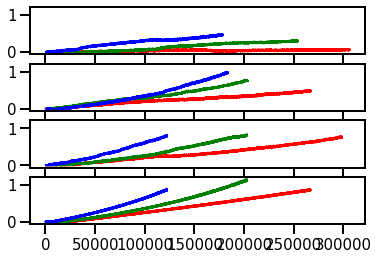

In [ ]:
#split the sequences. [i1 i2 i3] [o4]
# temperature and stress intensity are inputs
n_steps = 3

xsplit_1600_35, ysplit_1600_35 = split_sequences(data_1600_35, n_steps)
xsplit_1700_35, ysplit_1700_35 = split_sequences(data_1700_35, n_steps)
xsplit_1800_35, ysplit_1800_35 = split_sequences(data_1800_35, n_steps)

xsplit_1600_150, ysplit_1600_150 = split_sequences(data_1600_150, n_steps)
xsplit_1700_150, ysplit_1700_150 = split_sequences(data_1700_150, n_steps)
xsplit_1800_150, ysplit_1800_150 = split_sequences(data_1800_150, n_steps)

xsplit_1600_250, ysplit_1600_250 = split_sequences(data_1600_250, n_steps)
xsplit_1700_250, ysplit_1700_250 = split_sequences(data_1700_250, n_steps)
xsplit_1800_250, ysplit_1800_250 = split_sequences(data_1800_250, n_steps)
#Extrapolated
#75C
xsplit_1600_75, ysplit_1600_75 = split_sequences(data_1600_75, n_steps)
xsplit_1700_75, ysplit_1700_75 = split_sequences(data_1700_75, n_steps)
xsplit_1800_75, ysplit_1800_75 = split_sequences(data_1800_75, n_steps)
#200C
xsplit_1600_200, ysplit_1600_200 = split_sequences(data_1600_200, n_steps)
xsplit_1700_200, ysplit_1700_200 = split_sequences(data_1700_200, n_steps)
xsplit_1800_200, ysplit_1800_200 = split_sequences(data_1800_200, n_steps)
#300C
xsplit_1600_300, ysplit_1600_300 = split_sequences(data_1600_300, n_steps)
xsplit_1700_300, ysplit_1700_300 = split_sequences(data_1700_300, n_steps)
xsplit_1800_300, ysplit_1800_300 = split_sequences(data_1800_300, n_steps)
#400C
xsplit_1600_400, ysplit_1600_400 = split_sequences(data_1600_400, n_steps)
xsplit_1700_400, ysplit_1700_400 = split_sequences(data_1700_400, n_steps)
xsplit_1800_400, ysplit_1800_400 = split_sequences(data_1800_400, n_steps)
#500C
xsplit_1600_500, ysplit_1600_500 = split_sequences(data_1600_500, n_steps)
xsplit_1700_500, ysplit_1700_500 = split_sequences(data_1700_500, n_steps)
xsplit_1800_500, ysplit_1800_500 = split_sequences(data_1800_500, n_steps)

fig, (ax,ax2,ax3,ax4) = plt.subplots(4,1,sharex=True,sharey=True)
ax.plot(xsplit_1600_35[:,0,1], 'r--', label='1600N 35C') # 
ax.plot(xsplit_1700_35[:,0,1], 'g--', label='1700N 35C')
ax.plot(xsplit_1800_35[:,0,1], 'b--', label='1800N 35C')
ax2.plot(xsplit_1600_150[:,0,1], 'r-', label='1600N 150C') # 
ax2.plot(xsplit_1700_150[:,0,1], 'g--', label='1700N 150C')
ax2.plot(xsplit_1800_150[:,0,1], 'b--', label='1800N 150C')
ax3.plot(xsplit_1600_250[:,0,1], 'r--', label='1600N 250C') # 
ax3.plot(xsplit_1700_250[:,0,1], 'g--', label='1700N 250C')
ax3.plot(xsplit_1800_250[:,0,1], 'b--', label='1800N 250C')
ax4.plot(xsplit_1600_300[:,0,1], 'r--', label='1600N 300C') # 
ax4.plot(xsplit_1700_300[:,0,1], 'g--', label='1700N 300C')
ax4.plot(xsplit_1800_300[:,0,1], 'b--', label='1800N 300C')
#ax.legend()
plt.show()

# Predict On Data

In [ ]:
# Predict the data using the trained model.
yhat1600_35 = model.predict(xsplit_1600_35, verbose=1)
yhat1700_35 = model.predict(xsplit_1700_35, verbose=1)
yhat1800_35 = model.predict(xsplit_1800_35, verbose=1)
print('35C FINISHED')

yhat1600_150 = model.predict(xsplit_1600_150, verbose=1)
yhat1700_150 = model.predict(xsplit_1700_150, verbose=1)
yhat1800_150 = model.predict(xsplit_1800_150, verbose=1)
print('150C FINISHED')

yhat1600_250 = model.predict(xsplit_1600_250, verbose=1)
yhat1700_250 = model.predict(xsplit_1700_250, verbose=1)
yhat1800_250 = model.predict(xsplit_1800_250, verbose=1)
print('250C FINISHED')

#Extrapolated Data
#75C
yhat1600_75 = model.predict(xsplit_1600_75, verbose=1)
yhat1700_75 = model.predict(xsplit_1700_75, verbose=1)
yhat1800_75 = model.predict(xsplit_1800_75, verbose=1)
print('300C FINISHED')
#200C
yhat1600_200 = model.predict(xsplit_1600_200, verbose=1)
yhat1700_200 = model.predict(xsplit_1700_200, verbose=1)
yhat1800_200 = model.predict(xsplit_1800_200, verbose=1)
print('300C FINISHED')
#300C
yhat1600_300 = model.predict(xsplit_1600_300, verbose=1)
yhat1700_300 = model.predict(xsplit_1700_300, verbose=1)
yhat1800_300 = model.predict(xsplit_1800_300, verbose=1)
print('300C FINISHED')
#400C
yhat1600_400 = model.predict(xsplit_1600_400, verbose=1)
yhat1700_400 = model.predict(xsplit_1700_400, verbose=1)
yhat1800_400 = model.predict(xsplit_1800_400, verbose=1)
print('300C FINISHED')
#500C
yhat1600_500 = model.predict(xsplit_1600_500, verbose=1)
yhat1700_500 = model.predict(xsplit_1700_500, verbose=1)
yhat1800_500 = model.predict(xsplit_1800_500, verbose=1)
print('300C FINISHED')

5581/5581 [==============================] - 20s 4ms/step
35C FINISHED
5741/5741 [==============================] - 21s 4ms/step
150C FINISHED
3838/3838 [==============================] - 14s 4ms/step
250C FINISHED
3838/3838 [==============================] - 14s 4ms/step
300C FINISHED
3838/3838 [==============================] - 14s 4ms/step
300C FINISHED
3838/3838 [==============================] - 14s 4ms/step
300C FINISHED
3838/3838 [==============================] - 14s 4ms/step
300C FINISHED
3838/3838 [==============================] - 14s 4ms/step
300C FINISHED


In [ ]:
#Scale the Crack Series if it was Scaled During Training
# The crack length in millimeters is less than 3 so we likely will not need to scale.
scale_crackseries = 0 # 0=no 1=yes
if scale_crackseries > 0:
  Scaler_SC = MinMaxScaler()
  Scaler_SC = joblib.load('./Weights/Scaler_HT_TM_CS.save')
  print(Scaler.get_params)

  yhat1600_35 = Scaler_SC.inverse_transform(yhat1600_35)
  yhat1700_35 = Scaler_SC.inverse_transform(yhat1700_35)
  yhat1800_35 = Scaler_SC.inverse_transform(yhat1800_35)

  yhat1600_150 = Scaler_SC.inverse_transform(yhat1600_150)
  yhat1700_150 = Scaler_SC.inverse_transform(yhat1700_150)
  yhat1800_150 = Scaler_SC.inverse_transform(yhat1800_150)

  yhat1600_250 = Scaler_SC.inverse_transform(yhat1600_250)
  yhat1700_250 = Scaler_SC.inverse_transform(yhat1700_250)
  yhat1800_250 = Scaler_SC.inverse_transform(yhat1800_250)

# Plotting With Actual Data

In [ ]:
#read data in again to plot against prediction

cl1600_35 = crack_1600_35
cl1700_35 = crack_1700_35
cl1800_35 = crack_1800_35

cl1600_150 = crack_1600_150
cl1700_150 = crack_1700_150
cl1800_150 = crack_1800_150

cl1600_250 = crack_1600_250
cl1700_250 = crack_1700_250
cl1800_250 = crack_1800_250
print(cl1800_250)


[-0.02378494 -0.03914466 -0.05583271 ...  2.4373882   2.44295714
  2.46431167]


Plot against Original Data

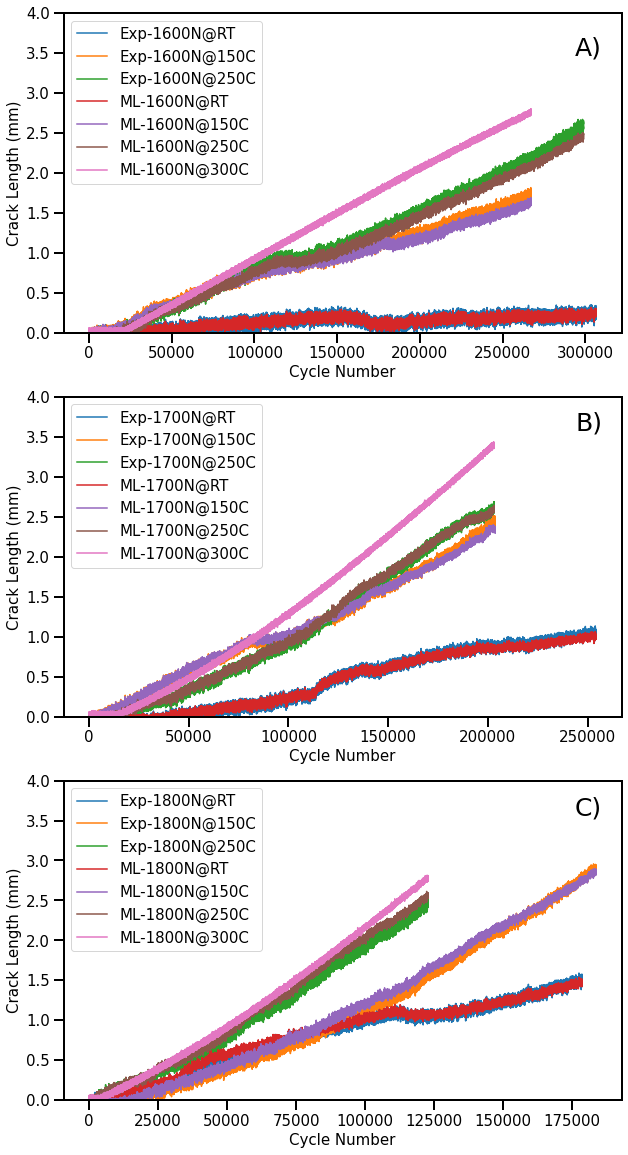

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,20))

ax1.plot(cl1600_35, label = 'Exp-1600N@RT')
ax1.plot(cl1600_150, label = 'Exp-1600N@150C')
ax1.plot(cl1600_250, label = 'Exp-1600N@250C')
ax1.plot(yhat1600_35, label = 'ML-1600N@RT')
ax1.plot(yhat1600_150, label = 'ML-1600N@150C')
ax1.plot(yhat1600_250, label = 'ML-1600N@250C')
ax1.plot(yhat1600_300, label = 'ML-1600N@300C')
ax1.set_xlabel("Cycle Number")
ax1.set_ylabel("Crack Length (mm)")
ax1.set_ylim([0, 4])
ax1.legend(loc=2)
ax1.annotate('A)',xy=(575, 1100), xycoords='figure points', fontsize=25, color='Black')

ax2.plot(cl1700_35, label = 'Exp-1700N@RT')
ax2.plot(cl1700_150, label = 'Exp-1700N@150C')
ax2.plot(cl1700_250, label = 'Exp-1700N@250C')
ax2.plot(yhat1700_35, label = 'ML-1700N@RT')
ax2.plot(yhat1700_150, label = 'ML-1700N@150C')
ax2.plot(yhat1700_250, label = 'ML-1700N@250C')
ax2.plot(yhat1700_300, label = 'ML-1700N@300C')
ax2.set_xlabel("Cycle Number")
ax2.set_ylabel("Crack Length (mm)")
ax2.legend()
ax2.set_ylim([0, 4])
ax2.annotate('B)',xy=(575, 725), xycoords='figure points', fontsize=25, color='Black')

ax3.plot(cl1800_35, label = 'Exp-1800N@RT')
ax3.plot(cl1800_150, label = 'Exp-1800N@150C')
ax3.plot(cl1800_250, label = 'Exp-1800N@250C')
ax3.plot(yhat1800_35, label = 'ML-1800N@RT')
ax3.plot(yhat1800_150, label = 'ML-1800N@150C')
ax3.plot(yhat1800_250, label = 'ML-1800N@250C')
ax3.plot(yhat1800_300, label = 'ML-1800N@300C')
ax3.set_xlabel('Cycle Number')
ax3.set_ylabel('Crack Length (mm)')
ax3.legend()
ax3.set_ylim([0, 4])
ax3.annotate('C)',xy=(575, 340), xycoords='figure points', fontsize=25, color='Black')

#ax3.xlabel("Cycle Number")
#ax1.ylabel("Crack Length (mm)")

plt.savefig('./Paper Images/CrackLength_HT_vT_TM.pdf', format='pdf',bbox_inches='tight')

Paper Figure

Text(475, 340, 'C) @ 300℃')

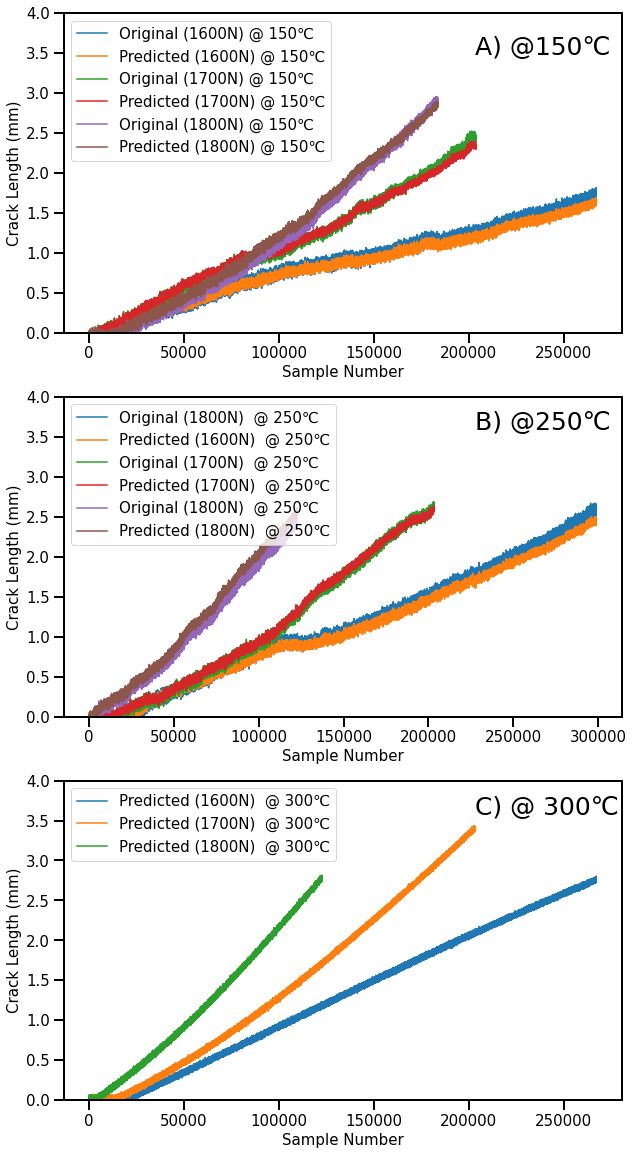

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,20))

#150C Data
ax1.plot(cl1600_150, label = 'Original (1600N) @ 150\u2103')
ax1.plot(yhat1600_150, label = 'Predicted (1600N) @ 150\u2103')
ax1.plot(cl1700_150, label = 'Original (1700N) @ 150\u2103')
ax1.plot(yhat1700_150, label = 'Predicted (1700N) @ 150\u2103')
ax1.plot(cl1800_150, label = 'Original (1800N) @ 150\u2103')
ax1.plot(yhat1800_150, label = 'Predicted (1800N) @ 150\u2103')
ax1.set_xlabel("Sample Number")
ax1.set_ylabel("Crack Length (mm)")
ax1.set_ylim([0, 4])
ax1.legend(loc=2)
ax1.annotate('A) @150\u2103',xy=(475, 1100), xycoords='figure points', fontsize=25, color='Black')

#250C Data
ax2.plot(cl1600_250, label = 'Original (1800N)  @ 250\u2103')
ax2.plot(yhat1600_250, label = 'Predicted (1600N)  @ 250\u2103')
ax2.plot(cl1700_250, label = 'Original (1700N)  @ 250\u2103')
ax2.plot(yhat1700_250, label = 'Predicted (1700N)  @ 250\u2103')
ax2.plot(cl1800_250, label = 'Original (1800N)  @ 250\u2103')
ax2.plot(yhat1800_250, label = 'Predicted (1800N)  @ 250\u2103')
ax2.set_xlabel("Sample Number")
ax2.set_ylabel("Crack Length (mm)")
ax2.legend()
ax2.set_ylim([0, 4])
ax2.annotate('B) @250\u2103',xy=(475, 725), xycoords='figure points', fontsize=25, color='Black')

#300C Data
ax3.plot(yhat1600_300, label = 'Predicted (1600N)  @ 300\u2103')
ax3.plot(yhat1700_300, label = 'Predicted (1700N)  @ 300\u2103')
ax3.plot(yhat1800_300, label = 'Predicted (1800N)  @ 300\u2103')
ax3.set_xlabel('Sample Number')
ax3.set_ylabel('Crack Length (mm)')
ax3.legend()
ax3.set_ylim([0, 4])
ax3.annotate('C) @ 300\u2103',xy=(475, 340), xycoords='figure points', fontsize=25, color='Black')

#plt.savefig('./Paper Images/fig2.pdf', format='pdf',bbox_inches='tight')

In [ ]:
print(yhat1800_150.shape)

(183685, 1)


Heatmap

In [ ]:
#Assemble arrays for 30C
min_arr = np.amin([len(yhat1600_35),len(yhat1700_35),len(yhat1800_35)])
arr_force = np.ones(min_arr).reshape(min_arr,1)
force_heatmap_35 = np.hstack((arr_force*1600,arr_force*1700,arr_force*1800))
crack_heatmap_35 = np.hstack((yhat1600_35[:min_arr,],yhat1700_35[:min_arr,],yhat1800_35[:min_arr,]))

arr_ti = np.arange(0,min_arr).reshape(min_arr,1)
time_heatmap_35 = np.hstack((arr_ti,arr_ti,arr_ti))

In [ ]:
#Assemble arrays for 250C
min_arr = np.amin([len(yhat1600_250),len(yhat1700_250),len(yhat1800_250)])
arr_force = np.ones(min_arr).reshape(min_arr,1)
force_heatmap_250 = np.hstack((arr_force*1600,arr_force*1700,arr_force*1800))
crack_heatmap_250 = np.hstack((yhat1600_250[:min_arr,],yhat1700_250[:min_arr,],yhat1800_250[:min_arr,]))

arr_ti = np.arange(0,min_arr).reshape(min_arr,1)
time_heatmap_250 = np.hstack((arr_ti,arr_ti,arr_ti))

In [ ]:
#Assemble arrays for 300C
min_arr = np.amin([len(yhat1600_300),len(yhat1700_300),len(yhat1800_300)])
arr_force = np.ones(min_arr).reshape(min_arr,1)
force_heatmap_300 = np.hstack((arr_force*1600,arr_force*1700,arr_force*1800))
crack_heatmap_300 = np.hstack((yhat1600_300[:min_arr,],yhat1700_300[:min_arr,],yhat1800_300[:min_arr,]))

arr_ti = np.arange(0,min_arr).reshape(min_arr,1)
time_heatmap_300 = np.hstack((arr_ti,arr_ti,arr_ti))

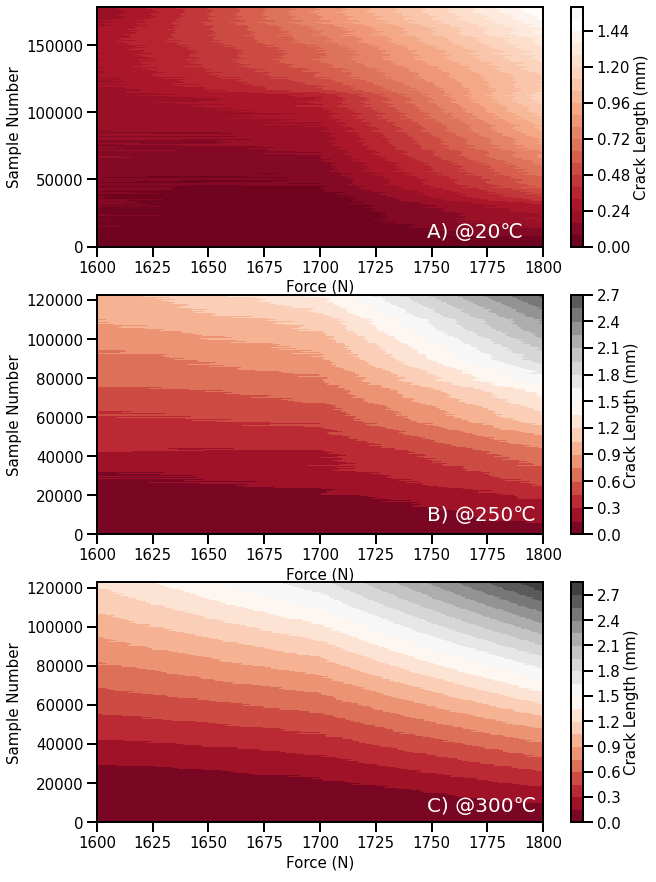

In [ ]:
opts = {'vmin': 0, 'vmax': 3, 'cmap': 'RdGy', 'levels':23}
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,15))

plot1 = ax1.contourf(force_heatmap_35,time_heatmap_35,crack_heatmap_35, **opts)
ax1.set_xlabel("Force (N)")
ax1.set_ylabel("Sample Number")
ax1.annotate('A) @20\u2103',xy=(0.65, 0.73), xycoords='figure fraction', fontsize=20, color='white')

plot2 = ax2.contourf(force_heatmap_250,time_heatmap_250,crack_heatmap_250, **opts)
ax2.set_xlabel("Force (N)")
ax2.set_ylabel("Sample Number")
ax2.annotate('B) @250\u2103',xy=(0.65, 0.41), xycoords='figure fraction', fontsize=20, color='white')

plot3 = ax3.contourf(force_heatmap_300,time_heatmap_300,crack_heatmap_300, **opts)
ax3.set_xlabel("Force (N)")
ax3.set_ylabel("Sample Number")
ax3.annotate('C) @300\u2103',xy=(0.65, 0.08), xycoords='figure fraction', fontsize=20, color='white')


cbar1 = fig.colorbar(plot1, ax=ax1)
cbar1.set_label('Crack Length (mm)')
cbar2 = fig.colorbar(plot2, ax=ax2)
cbar2.set_label('Crack Length (mm)')
cbar3 = fig.colorbar(plot3, ax=ax3)
cbar3.set_label('Crack Length (mm)')

#plt.savefig('./Paper Images/Heatmap_HT_TM_6_8_21.pdf', format='pdf',bbox_inches='tight')
#plt.savefig('./Paper Images/fig3.png',  dpi=600, bbox_inches='tight')

**DaDn Plots**

In [ ]:
def create_da_dk_actual(filename, crack_length, change):
  file = pd.read_csv(filename)
  data_array = np.asarray(file)

  stress_intensity = data_array[:, 1].reshape(len(data_array), 1)
  stress_intensity = Scaler.transform(stress_intensity)

  da = []
  dk = []

  for i in range(len(crack_length) - change):
    da.append(crack_length[i + change] - crack_length[i])

  for i in range(len(stress_intensity) - change):
    dk.append(stress_intensity[i + change] - stress_intensity[i])

  return (np.asarray(da)), (np.asarray(dk))

In [ ]:
def dadn_fn(x, c, n):
    return np.sign(x)*c*np.abs(x)**n

In [ ]:
def create_da_dk_intermediate(crack_length, stress_intensity, change, use_inter):
  #use_inter = 1 #0=no 1=yes
  #
  # MATLAB CODE used for Experiment
  #
  #triang_x = [20 30];
  #triang_y = interp1(dK_I_1800(:,:,1), a_1800(:,:,1), triang_x);
  #slope = diff(triang_y)/diff(triang_x);
  #
  dadn = []
  dk = []

  minarr = int(np.min([len(crack_length),len(stress_intensity)]))
  startarr = int(0.5*minarr) #start at 50% of array
  stoparr = int(0.8*minarr) #stop at 80% of array
  if use_inter>0:
    dk = np.arange(20,80,1) #delta k
    a = np.asarray(crack_length[startarr:stoparr].flatten())
    k = np.asarray(stress_intensity[startarr:stoparr].flatten())
    len_arr = int(np.floor(len(a)/change))
    da_in = np.zeros(len_arr)
    dk_in = np.zeros(len_arr)
    for i in range(0,len_arr-1):
      da_in[i]=((a[(i+1)*change] - a[i*change])/(change/512*10))
      dk_in[i]=((k[(i+1)*change] - k[i*change])*np.sqrt(1000))

    print(da_in)
    print(dk_in)

    #interpolate function was 1d arrays...here we come reshape
    #dadn_f = interpolate.interp1d(dk_in,da_in,fill_value='extrapolate')
    #dadn = dadn_f(dk)
    popt, pcov = curve_fit(dadn_fn, dk_in, da_in,)
    print('fit: c=%10.3e, n=%10.3e' % tuple(popt))
    dadn = dadn_fn(dk, *popt)
    #slope = np.diff(triang_y)/np.diff(triang_x)
  else:
    #forward finite difference
    all_data = 0 #use fit data only=0 use all data =1
    if all_data > 0:
      len_arr = int(startarr/change)+int(np.floor((stoparr-startarr)/change))
      #crack length units coming in will have units mm and we want mm/cycle
      for i in range(int(startarr/change),len_arr-1):
        dadn.append((crack_length[(i+1)*change] - crack_length[i*change])/(change/512))

      #stress intensity coming in will have units MPa*sqrt(mm) and we want MPa*sqrt(m)
      for i in range(int(startarr/change),len_arr-1):
        dk.append((stress_intensity[(i+1)*change] - stress_intensity[i*change])*np.sqrt(1000))
    else:
      len_arr = int(np.floor(len(crack_length)/change))
      #crack length units coming in will have units mm and we want mm/cycle
      for i in range(0,len_arr-1):
        dadn.append((crack_length[(i+1)*change] - crack_length[i*change])/(change/512*10))

      #stress intensity coming in will have units MPa*sqrt(mm) and we want MPa*sqrt(m)
      for i in range(0,len_arr-1):
        dk.append((stress_intensity[(i+1)*change] - stress_intensity[i*change])*np.sqrt(1000))

  return np.asarray(dadn), np.asarray(dk)

In [ ]:
change = 512
#python is driving me crazy with these 2d arrays with one column wtf python. that is why there are all these reshapes...
#interpolated da/dn values
print('1600 35C');da1600_35, dk1600_35 = create_da_dk_intermediate(yhat1600_35, calc_stress_intensity(force_1600_35,crack_1600_35,0).reshape((len(crack_1600_35),1)), change,1)
print('1700 35C');da1700_35, dk1700_35 = create_da_dk_intermediate(yhat1700_35, calc_stress_intensity(force_1700_35,crack_1700_35,0).reshape((len(crack_1700_35),1)), change,1)
print('1800 35C');da1800_35, dk1800_35 = create_da_dk_intermediate(yhat1800_35, calc_stress_intensity(force_1800_35,crack_1800_35,0).reshape((len(crack_1800_35),1)), change,1)

print('1600 75C');da1600_75, dk1600_75 = create_da_dk_intermediate(yhat1600_75, calc_stress_intensity(force_1600_75,crack_1600_75.reshape((len(crack_1600_75),1)),0), change,1)
print('1700 75C');da1700_75, dk1700_75 = create_da_dk_intermediate(yhat1700_75, calc_stress_intensity(force_1700_75,crack_1700_75.reshape((len(crack_1700_75),1)),0), change,1)
print('1800 75C');da1800_75, dk1800_75 = create_da_dk_intermediate(yhat1800_75, calc_stress_intensity(force_1800_75,crack_1800_75.reshape((len(crack_1800_75),1)),0), change,1)

print('1600 150C');da1600_150, dk1600_150 = create_da_dk_intermediate(yhat1600_150, calc_stress_intensity(force_1600_150,crack_1600_150.reshape((len(crack_1600_150),1)),0), change,1)
print('1700 150C');da1700_150, dk1700_150 = create_da_dk_intermediate(yhat1700_150, calc_stress_intensity(force_1700_150,crack_1700_150.reshape((len(crack_1700_150),1)),0), change,1)
print('1800 150C');da1800_150, dk1800_150 = create_da_dk_intermediate(yhat1800_150, calc_stress_intensity(force_1800_150,crack_1800_150.reshape((len(crack_1800_150),1)),0), change,1)

print('1600 200C');da1600_200, dk1600_200 = create_da_dk_intermediate(yhat1600_200, calc_stress_intensity(force_1600_200,crack_1600_200.reshape((len(crack_1600_200),1)),0), change,1)
print('1700 200C');da1700_200, dk1700_200 = create_da_dk_intermediate(yhat1700_200, calc_stress_intensity(force_1700_200,crack_1700_200.reshape((len(crack_1700_200),1)),0), change,1)
print('1800 200C');da1800_200, dk1800_200 = create_da_dk_intermediate(yhat1800_200, calc_stress_intensity(force_1800_200,crack_1800_200.reshape((len(crack_1800_200),1)),0), change,1)

print('1600 250C');da1600_250, dk1600_250 = create_da_dk_intermediate(yhat1600_250, calc_stress_intensity(force_1600_250,crack_1600_250.reshape((len(crack_1600_250),1)),0), change,1)
print('1700 250C');da1700_250, dk1700_250 = create_da_dk_intermediate(yhat1700_250, calc_stress_intensity(force_1700_250,crack_1700_250.reshape((len(crack_1700_250),1)),0), change,1)
print('1800 250C');da1800_250, dk1800_250 = create_da_dk_intermediate(yhat1800_250, calc_stress_intensity(force_1800_250,crack_1800_250.reshape((len(crack_1800_250),1)),0), change,1)

print('1600 300C');da1600_300, dk1600_300 = create_da_dk_intermediate(yhat1600_300, calc_stress_intensity(force_1600_300,crack_1600_300,0).reshape((len(crack_1600_300),1)), change,1)
print('1700 300C');da1700_300, dk1700_300 = create_da_dk_intermediate(yhat1700_300, calc_stress_intensity(force_1700_300,crack_1700_300,0).reshape((len(crack_1700_300),1)), change,1)
print('1800 300C');da1800_300, dk1800_300 = create_da_dk_intermediate(yhat1800_300, calc_stress_intensity(force_1800_300,crack_1800_300,0).reshape((len(crack_1800_300),1)), change,1)

print('1600 400C');da1600_400, dk1600_400 = create_da_dk_intermediate(yhat1600_400, calc_stress_intensity(force_1600_400,crack_1600_400,0).reshape((len(crack_1600_400),1)), change,1)
print('1700 400C');da1700_400, dk1700_400 = create_da_dk_intermediate(yhat1700_400, calc_stress_intensity(force_1700_400,crack_1700_400,0).reshape((len(crack_1700_400),1)), change,1)
print('1800 400C');da1800_400, dk1800_400 = create_da_dk_intermediate(yhat1800_400, calc_stress_intensity(force_1800_400,crack_1800_400,0).reshape((len(crack_1800_400),1)), change,1)

print('1600 500C');da1600_500, dk1600_500 = create_da_dk_intermediate(yhat1600_500, calc_stress_intensity(force_1600_500,crack_1600_500,0).reshape((len(crack_1600_500),1)), change,1)
print('1700 500C');da1700_500, dk1700_500 = create_da_dk_intermediate(yhat1700_500, calc_stress_intensity(force_1700_500,crack_1700_500,0).reshape((len(crack_1700_500),1)), change,1)
print('1800 500C');da1800_500, dk1800_500 = create_da_dk_intermediate(yhat1800_500, calc_stress_intensity(force_1800_500,crack_1800_500,0).reshape((len(crack_1800_500),1)), change,1)

1600 35C
0
100000
200000
300000
[-2.28446722e-03  6.14859462e-03 -6.25280142e-03  7.01102018e-03
 -8.72787237e-03 -1.57030821e-03  8.29287767e-03 -1.80994868e-03
  1.31002665e-03 -6.33550286e-03  4.16978002e-03 -8.99267197e-04
 -1.70348287e-03 -1.04774833e-03  5.40626049e-04  1.75234675e-03
 -1.78788304e-03  1.58419609e-03 -3.03576589e-03  2.61647701e-03
 -3.06450129e-03  1.88015699e-03 -1.88159943e-03  4.23488617e-03
 -1.36715174e-03 -1.93072557e-03  1.80680156e-03 -3.79655361e-03
  2.91645527e-05 -4.67073917e-03  3.35024595e-03 -2.98635960e-03
 -4.40001488e-05  4.70209122e-04 -2.65734196e-03  4.58258390e-03
  5.29562831e-03 -7.54886270e-03  4.02909517e-03 -1.63185596e-03
 -9.92986560e-03  4.53090072e-03  3.44380736e-03  1.26670003e-03
  3.68773937e-03 -1.23012900e-02  7.96037316e-03 -5.26124239e-04
  4.08505201e-03 -7.24899769e-04 -7.83175230e-03  5.82067370e-03
  3.17029953e-03 -1.34072304e-03 -6.15021586e-03  5.40599823e-03
  8.86887312e-04 -8.22192430e-04 -2.12451816e-03 -2.162444

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[-4.81886268e-03  2.66548395e-03  1.28613710e-03 -1.95611715e-03
 -1.29064918e-03 -2.27985978e-03  4.84473109e-03  3.28779221e-04
 -3.08591127e-04 -5.40798903e-04 -1.03986263e-04 -5.14036417e-04
  2.14668512e-03 -1.20233893e-03 -7.97712803e-04  1.79663897e-03
 -9.57983732e-04 -1.13171339e-04  4.13841009e-04 -2.70992517e-04
 -8.84062052e-04  2.23508477e-03  7.45362043e-04  1.38661861e-03
 -2.03066468e-03 -2.94029713e-05  2.02262998e-03 -2.22820044e-03
 -9.97710228e-04  1.35952234e-04  1.88508034e-03 -2.28483081e-03
  3.21226716e-03 -6.97481632e-04 -5.33813238e-04  1.50048733e-04
 -1.43996477e-03  1.34749413e-03 -1.27763748e-03  1.42542720e-03
  9.71472263e-04 -4.43959236e-04 -1.20089650e-03  1.35990977e-03
  4.54002619e-04  2.72279382e-03 -8.18711519e-04 -3.26914191e-03
  1.41207576e-03  2.03737617e-03 -6.91509247e-04  3.53217125e-04
 -1.18776560e-03 -9.65011120e-04  5.73694706e-04  8.28266144e-04
  1.59896612e-03 -1.57670379e-03 -1.68319345e-03  2.46812701e-03
  3.61102819e-04 -1.32166

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


100000
200000
[ 2.57807970e-03  3.11509371e-03 -2.19078064e-03  1.56276226e-03
  2.28352547e-03 -3.18769217e-03  3.01828384e-03 -1.04542971e-03
  4.44803238e-03 -4.10282612e-03 -7.87138939e-04  1.68652534e-03
  1.59271955e-03 -8.65662098e-04 -2.88219452e-03  3.40000391e-03
  1.45697594e-03 -2.04713345e-03  8.25020075e-03 -4.19183969e-03
  1.53493881e-03 -3.01575661e-04 -3.73638868e-03  5.39152622e-03
  3.38804722e-04  2.41222382e-03 -6.43241405e-04 -7.40396976e-04
 -3.84700298e-04  3.48980427e-03 -5.51866293e-03  4.73058224e-03
  4.40728664e-04 -3.01946402e-03  2.20342875e-03 -1.10197067e-03
  3.97604704e-03 -8.55518579e-03  4.33185101e-03  4.97246981e-03
 -5.59139252e-04  5.41245937e-04 -1.48518085e-03  1.29511356e-03
  8.35883617e-04  3.21725607e-03 -3.78100872e-03 -1.09124184e-03
  1.05153322e-03  4.64901924e-03  2.31987238e-03 -2.94953585e-03
 -7.76195526e-04 -2.64370441e-03  4.93162870e-03 -1.11266375e-03
  4.37029600e-03 -1.09699965e-03 -6.50966167e-04 -3.63969803e-04
  1.0989069

In [ ]:
#finite difference da/dn values
da1600_35_fd, dk1600_35_fd = create_da_dk_intermediate(yhat1600_35, calc_stress_intensity(force_1600_35,crack_1600_35,0).reshape((len(force_1600_35),1)), change,0)
da1700_35_fd, dk1700_35_fd = create_da_dk_intermediate(yhat1700_35, calc_stress_intensity(force_1700_35,crack_1700_35,0).reshape((len(force_1700_35),1)), change,0)
da1800_35_fd, dk1800_35_fd = create_da_dk_intermediate(yhat1800_35, calc_stress_intensity(force_1800_35,crack_1800_35,0).reshape((len(force_1800_35),1)), change,0)

da1600_75_fd, dk1600_75_fd = create_da_dk_intermediate(yhat1600_75, calc_stress_intensity(force_1600_75,crack_1600_75,0).reshape((len(force_1600_75),1)), change,0)
da1700_75_fd, dk1700_75_fd = create_da_dk_intermediate(yhat1700_75, calc_stress_intensity(force_1700_75,crack_1700_75,0).reshape((len(force_1700_75),1)), change,0)
da1800_75_fd, dk1800_75_fd = create_da_dk_intermediate(yhat1800_75, calc_stress_intensity(force_1800_75,crack_1800_75,0).reshape((len(force_1800_75),1)), change,0)

da1600_150_fd, dk1600_150_fd = create_da_dk_intermediate(yhat1600_150, calc_stress_intensity(force_1600_150,crack_1600_150.reshape((len(force_1600_150),1)),0), change,0)
da1700_150_fd, dk1700_150_fd = create_da_dk_intermediate(yhat1700_150, calc_stress_intensity(force_1700_150,crack_1700_150.reshape((len(force_1700_150),1)),0), change,0)
da1800_150_fd, dk1800_150_fd = create_da_dk_intermediate(yhat1800_150, calc_stress_intensity(force_1800_150,crack_1800_150.reshape((len(force_1800_150),1)),0), change,0)

da1600_200_fd, dk1600_200_fd = create_da_dk_intermediate(yhat1600_200, calc_stress_intensity(force_1600_200,crack_1600_200.reshape((len(force_1600_200),1)),0), change,0)
da1700_200_fd, dk1700_200_fd = create_da_dk_intermediate(yhat1700_200, calc_stress_intensity(force_1700_200,crack_1700_200.reshape((len(force_1700_200),1)),0), change,0)
da1800_200_fd, dk1800_200_fd = create_da_dk_intermediate(yhat1800_200, calc_stress_intensity(force_1800_200,crack_1800_200.reshape((len(force_1800_200),1)),0), change,0)

da1600_250_fd, dk1600_250_fd = create_da_dk_intermediate(yhat1600_250, calc_stress_intensity(force_1600_250,crack_1600_250.reshape((len(force_1600_250),1)),0), change,0)
da1700_250_fd, dk1700_250_fd = create_da_dk_intermediate(yhat1700_250, calc_stress_intensity(force_1700_250,crack_1700_250.reshape((len(force_1700_250),1)),0), change,0)
da1800_250_fd, dk1800_250_fd = create_da_dk_intermediate(yhat1800_250, calc_stress_intensity(force_1800_250,crack_1800_250.reshape((len(force_1800_250),1)),0), change,0)

da1600_300_fd, dk1600_300_fd = create_da_dk_intermediate(yhat1600_300, calc_stress_intensity(force_1600_300,crack_1600_300,0).reshape((len(force_1600_300),1)), change,0)
da1700_300_fd, dk1700_300_fd = create_da_dk_intermediate(yhat1700_300, calc_stress_intensity(force_1700_300,crack_1700_300,0).reshape((len(force_1700_300),1)), change,0)
da1800_300_fd, dk1800_300_fd = create_da_dk_intermediate(yhat1800_300, calc_stress_intensity(force_1800_300,crack_1800_300,0).reshape((len(force_1800_300),1)), change,0)

da1600_400_fd, dk1600_400_fd = create_da_dk_intermediate(yhat1600_400, calc_stress_intensity(force_1600_400,crack_1600_400,0).reshape((len(force_1600_400),1)), change,0)
da1700_400_fd, dk1700_400_fd = create_da_dk_intermediate(yhat1700_400, calc_stress_intensity(force_1700_400,crack_1700_400,0).reshape((len(force_1700_400),1)), change,0)
da1800_400_fd, dk1800_400_fd = create_da_dk_intermediate(yhat1800_400, calc_stress_intensity(force_1800_400,crack_1800_400,0).reshape((len(force_1800_400),1)), change,0)

da1600_500_fd, dk1600_500_fd = create_da_dk_intermediate(yhat1600_500, calc_stress_intensity(force_1600_500,crack_1600_500,0).reshape((len(force_1600_500),1)), change,0)
da1700_500_fd, dk1700_500_fd = create_da_dk_intermediate(yhat1700_500, calc_stress_intensity(force_1700_500,crack_1700_500,0).reshape((len(force_1700_500),1)), change,0)
da1800_500_fd, dk1800_500_fd = create_da_dk_intermediate(yhat1800_500, calc_stress_intensity(force_1800_500,crack_1800_500,0).reshape((len(force_1800_500),1)), change,0)

0
100000
200000
300000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000
0
100000
200000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000
0
100000
200000
0
100000
200000
0
100000


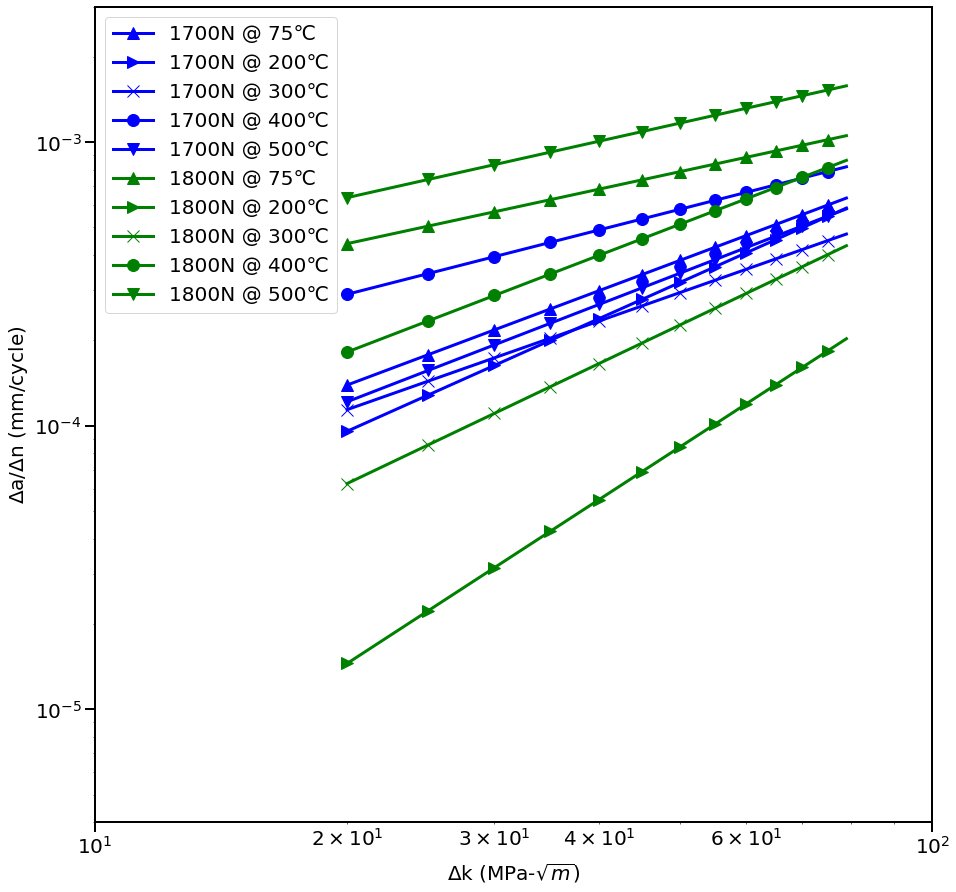

In [ ]:
plt.figure(figsize=(15,15))
plt.rc('font', size=20)
#1600N
#plt.scatter(dk1600_35, da1600_35, label = '1600N @ 35C')
#plt.scatter(dk1600_75, da1600_75, label = '1600N @ 75C')
#plt.scatter(dk1600_150, da1600_150, label = '1600N @ 150C')
#plt.scatter(dk1600_250, da1600_250, label = '1600N @ 250C')
#plt.scatter(dk1600_300, da1600_300, label = '1600N @ 300C')
#plt.scatter(dk1600_300_fd, da1600_300_fd, label = '1600N @ 300C')
#plt.scatter(dk1600_400, da1600_400, label = '1600N @ 400C')
#plt.scatter(dk1600_500, da1600_500, label = '1600N @ 500C')

#1700N
#plt.scatter(dk1700_35_fd, da1700_35_fd, label = '1700N @ 35C')
plt.plot(dk1700_75, da1700_75, 'b^-', label = '1700N @ 75\u2103', linewidth=3, markersize=12,markevery=5)
#plt.scatter(dk1700_75, da1700_75, label = '1700N @ 75C')
#plt.scatter(dk1700_75_fd, da1700_75_fd, label = '1700N @ 75C')
#plt.scatter(dk1700_150, da1700_150, label = '1700N @ 150C')
plt.plot(dk1700_200, da1700_200, 'b>-', label = '1700N @ 200\u2103', linewidth=3, markersize=12,markevery=5)
#plt.scatter(dk1700_200, da1700_200, label = '1700N @ 200C')
#plt.scatter(dk1700_250, da1700_250, label = '1700N @ 250C')
plt.plot(dk1700_300, da1700_300, 'bx-', label = '1700N @ 300\u2103', linewidth=3, markersize=12,markevery=5)
#plt.plot(dk1700_300_fd, da1700_300_fd, 'b,-', label = '1700N @ 300C')
plt.plot(dk1700_400, da1700_400, 'bo-', label = '1700N @ 400\u2103', linewidth=3, markersize=12,markevery=5)
plt.plot(dk1700_500, da1700_500, 'bv-', label = '1700N @ 500\u2103', linewidth=3, markersize=12,markevery=5)

#1800N
#plt.scatter(dk1800_35_fd, da1800_35_fd, label = '1800N @ 35C')
plt.plot(dk1800_75, da1800_75, 'g^-', label = '1800N @ 75\u2103', linewidth=3, markersize=12,markevery=5)
#plt.scatter(dk1800_75_fd, da1800_75_fd, label = '1800N @ 75C')
#plt.scatter(dk1800_150, da1800_150, label = '180N @ 150C')
plt.plot(dk1800_200, da1800_200, 'g>-', label = '1800N @ 200\u2103', linewidth=3, markersize=12,markevery=5)
#plt.scatter(dk1800_250, da1800_250, label = '1800N @ 250C')
plt.plot(dk1800_300, da1800_300, 'gx-', label = '1800N @ 300\u2103', linewidth=3, markersize=12,markevery=5)
#plt.plot(dk1800_300_fd, da1800_300_fd, label = '1800N @ 300C')
plt.plot(dk1800_400, da1800_400, 'go-', label = '1800N @ 400\u2103', linewidth=3, markersize=12,markevery=5)
plt.plot(dk1800_500, da1800_500, 'gv-', label = '1800N @ 500\u2103', linewidth=3, markersize=12,markevery=5)


plt.xscale("log")
plt.yscale("log")
plt.xlim([10, 100])
plt.ylim([4e-6, 3e-3])
plt.xlabel('$\Delta$k (MPa-$\sqrt{m}$)')
plt.ylabel('$\Delta$a/$\Delta$n (mm/cycle)')
plt.legend()
plt.savefig('./Paper Images/fig4.pdf', format='pdf',bbox_inches='tight')